### Домашнее задание
1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000).
p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:
- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

Ссылки

https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

%matplotlib inline

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [5]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [6]:
def get_plot(y_test, list_y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1])  
    
    num_model = 0
    for y_score in list_y_score:
        name_model = str(list_name_model[num_model])
        fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
        lw = 2
        plt.plot(fpr, tpr, lw=lw, label='ROC curve ' + name_model)
        num_model += 1
        
      
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

In [7]:
def get_prediction(name_model, coef_b_for_f):
    if name_model == 'LogisticRegression':
        model = LogisticRegression(random_state = 42)
    elif name_model == 'RandomForest':
        model = RandomForestClassifier(random_state = 42)
    elif name_model == 'GradientBoosting':
        model = GradientBoostingClassifier(random_state = 42)

    print('Model:', name_model)
    classifier = Pipeline([
        ('features',feats),
        ('classifier', model),
        ])

    #запустим кросс-валидацию
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print('CV score is {}+-{}'.format(cv_score, cv_score_std))

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+coef_b_for_f**2)*(precision * recall) / (coef_b_for_f**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
    print()
    list_y_score.append(y_score)
    list_precision.append(precision[ix])
    list_recall.append(recall[ix])
    list_f_score.append(fscore[ix])
    list_roc_auc.append(roc_auc_score(y_test, y_score))

Model: LogisticRegression
CV score is 0.7867401104915408+-0.00852135511666111
Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838

Model: RandomForest
CV score is 0.7734501681056019+-0.007171140345435727
Best Threshold=0.350000, F-Score=0.719, Precision=0.643, Recall=0.816

Model: GradientBoosting
CV score is 0.8025124517417064+-0.007075372179995901
Best Threshold=0.394947, F-Score=0.740, Precision=0.698, Recall=0.788



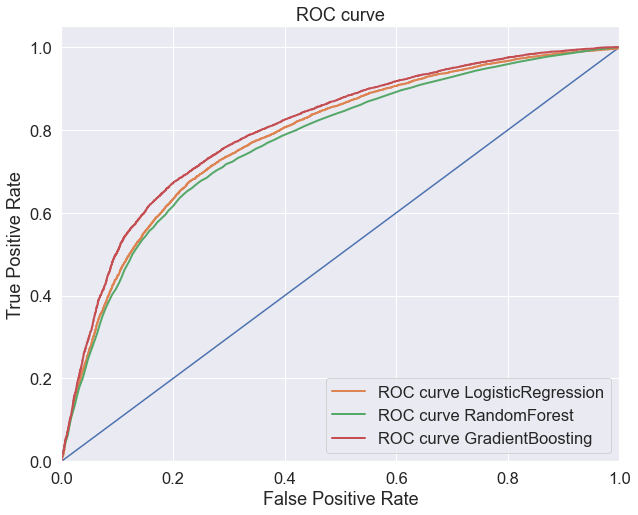

In [8]:
list_name_model = ['LogisticRegression', 'RandomForest', 'GradientBoosting']
list_precision = []
list_recall = []
list_f_score = []
list_roc_auc = []
list_y_score = []
for name_model in list_name_model:
    get_prediction(name_model, 1)
get_plot(y_test, list_y_score)

In [9]:
result = pd.DataFrame()
result['Model'] = list_name_model
result['Precision'] = list_precision
result['Recall'] = list_recall
result['F_score'] = list_f_score
result['ROC_AUC'] = list_roc_auc
result = result.reset_index(drop=True)
result

,Model,Precision,Recall,F_score,ROC_AUC
0,LogisticRegression,0.647431,0.837558,0.730323,0.784035
1,RandomForest,0.642669,0.815553,0.718863,0.771037
2,GradientBoosting,0.697848,0.788134,0.740248,0.802615


Вывод: при использовании стандартных моделей без настройки гиперпараметров наиболее точный результат показывает модель Градиентного Бустинга. 

Рассмотрим задачу:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:
- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [10]:
def get_metrics(All_obj, True_positive, label_true, real_positive):
    False_positive = label_true - True_positive
    False_negative = real_positive - True_positive
    True_negative = All_obj - label_true - real_positive + True_positive
    Precision = True_positive / (True_positive + False_positive)
    Recall = True_positive / (True_positive + False_negative)
    FPR = False_positive / (False_positive + True_negative)
    TPR = True_positive / (True_positive + False_negative)
    return True_positive, False_positive, False_negative, True_negative, Precision, Recall, FPR, TPR

In [11]:
All_obj = 100000
label_true_1 = 100
label_true_2 = 1000
True_positive = 90
real_positive = 100

True_positive_1, False_positive_1, False_negative_1, True_negative_1, Precision_1, Recall_1, FPR_1, TPR_1 = get_metrics(All_obj, True_positive, label_true_1, real_positive)
conf_matrix_model_1 =[ [True_positive_1, False_positive_1], [True_negative_1, False_negative_1]]
print('Confusion matrix for 1 model')
print(conf_matrix_model_1)
print()

True_positive_2, False_positive_2, False_negative_2, True_negative_2, Precision_2, Recall_2, FPR_2, TPR_2 = get_metrics(All_obj, True_positive, label_true_2, real_positive)
conf_matrix_model_2 =[ [True_positive_2, False_positive_2], [True_negative_2, False_negative_2]]
print('Confusion matrix for 2 model')
print(conf_matrix_model_2)

Confusion matrix for 1 model
[[90, 10], [99890, 10]]

Confusion matrix for 2 model
[[90, 910], [98990, 10]]


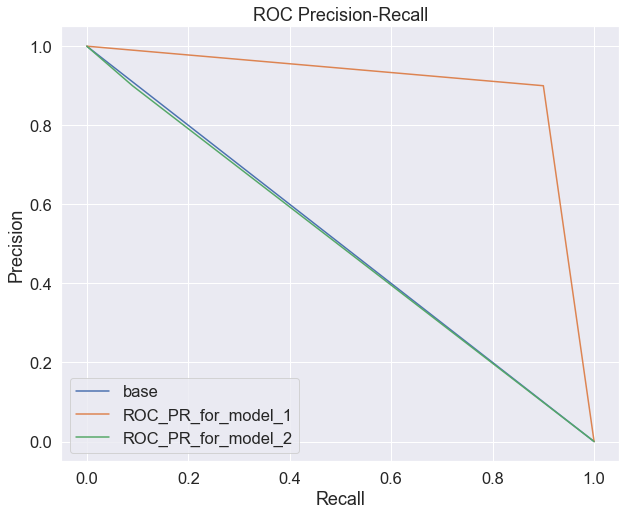

In [12]:
plt.figure(figsize=(10, 8))
plt.plot([1, 0], [0, 1], label='base')
plt.plot([1, Precision_1, 0], [0, Recall_1, 1], label='ROC_PR_for_model_1')
plt.plot([1, Precision_2, 0], [0, Recall_2, 1], label='ROC_PR_for_model_2')
plt.legend()
plt.title('ROC Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

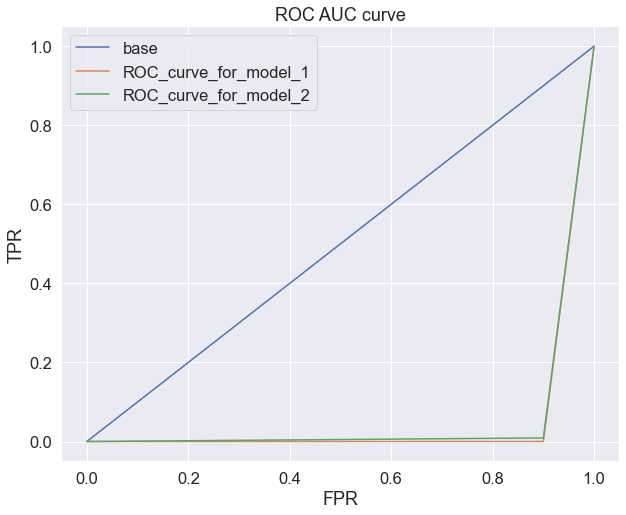

In [13]:
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], label='base')
plt.plot([0, TPR_1, 1], [0, FPR_1, 1], label='ROC_curve_for_model_1')
plt.plot([0, TPR_2, 1], [0, FPR_2, 1], label='ROC_curve_for_model_2')
plt.legend()
plt.title('ROC AUC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

Выводы:
1. Исходя из приведенных выше графиков, можно заметить, что precision_recall_curve больше подходит в случае сильного дисбаланса классов, чем roc_auc_curve, по нему легче сделать вывод, какая модель лучше. 
2. Первая модель в данном случае лучше второй